## LAB: **ATTENTION IN COMPUTER VISION**

---

***STUDENT(S):***

*Pablo Santa Cruz Sánchez - 100428988@alumnos.uc3m.es*

*Pablo Tomás Campos Fernández - 100406000@alumnos.uc3m.es*

*Laura Martínez Díaz - 100428953@alumnos.uc3m.es*

---

In the context of machine learning, **attention** is a technique that mimics cognitive attention, defined as the ability to choose and concentrate on relevant stimuli. In other words, **attention is a method that tries to enhance the important parts while fading out the non-relevant information**. The idea of Attention Mechanisms was first popularly introduced in the domain of Natural Language Processing (NLP) in the NeurIPS 2017 paper by Google Brain, titled ["**Attention Is All You Need**"](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf).

In computer vision, attention has found its way into several applications, such as in the domains of image classification, image segmentation, and image captioning.

<figure>
<center><img src="https://miro.medium.com/max/1400/1*sRy3ukQziKP0TSQqlz3LCg.webp" width="80%"></center>
<figcaption align = "center"> Attention maps in an image captioning problem. </figcaption>
</figure>

# **CBAM**: Convolutional Block Attention Module

In this lab we are going to implement one of the most popular attention modules in computer vision: the **Convolutional Block Attention Module (CBAM)**. It contains two sequential sub-modules called the **Channel Attention Module (CAM)** and the **Spatial Attention Module (SAM)**, which are applied in that particular order. The authors of the [paper](https://openaccess.thecvf.com/content_ECCV_2018/papers/Sanghyun_Woo_Convolutional_Block_Attention_ECCV_2018_paper.pdf) point out that CBAM is applied at every convolutional block in deep networks to get subsequent "*Refined Feature Maps*" from the "*Input Intermediate Feature Maps*".

Before going through the specifics and implementation of Spatial and Channel Attention respectively, let's get to know what these terms mean and why they are essential.

*   ***Spatial*** refers to the domain space encapsulated within each **feature map**. Spatial attention represents the attention mechanism/attention mask on the feature map, or a single cross-sectional slice of the tensor. Refining the feature maps using Spatial Attention, we are **enhancing the input to the subsequent convolutional layers** which thus improves the performance of the model.
*   ***Channel*** attention essentially provides a weight for each channel and thus **enhances those particular channels which are most contributing towards learning** and thus boosts the overall model performance.




# Dataset

In this lab we are going yo apply CBAM in a classification problem. For that, we have selected the [STL-10 dataset](https://cs.stanford.edu/~acoates/stl10/), including a white patch to some images (as displayed below). The task is to create a neural network that classifies both types of images.

<figure>
<center><img src="https://miro.medium.com/max/1018/1*rzmgXEF2VJbw6IAB2bA-Cw.webp" width="55%"></center>
<figcaption align = "center"> STL images. Those images labeled as 1 belong to the class whose images have a white patch while those labeled as 0 are the ones that do not have the white patch.</figcaption>
</figure>

# Imports

In [ ]:
import os
from PIL import Image
import torchvision
from torchvision.datasets import STL10
from torchvision import datasets, transforms, utils
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!


# PART I: Loading and preprocessing STL-10 dataset

Download the STL-10 dataset using torchvision.



In [ ]:
# Original dataset
data_train = STL10("stl10_train", split='train', download=True)
data_test = STL10("stl10_test", split='test', download=True)

100%|██████████| 2640397119/2640397119 [04:49<00:00, 9114348.73it/s]


Extracting stl10_train/stl10_binary.tar.gz to stl10_train


100%|██████████| 2640397119/2640397119 [04:30<00:00, 9755675.56it/s]


Extracting stl10_test/stl10_binary.tar.gz to stl10_test


Now we define a dataset class to define the corrupted version of the images and their labels. It takes as input the images from the original dataset.

In [ ]:
class STL10_patch(Dataset):

  def __init__(self, dataset_og):

    self.dataset_og = dataset_og

  def __len__(self):
    return len(self.dataset_og)

  def __getitem__(self, index):

    image = self.dataset_og.__getitem__(index)[0]

    # Split in image and labels
    stl_image, label = self.corrupt_patch(image)

    # Transform image
    stl_image = self.transform_img(Image.fromarray(stl_image))

    return stl_image, label

  def corrupt_patch(self, img):

    img = np.array(img)

    corrupt = np.random.randint(2)

    label = 0.

    if corrupt:
      # Set label to 1 and add the patch
      label = 1.
      pos_x = np.random.randint(96-16)
      pos_y = np.random.randint(96-16)
      img[pos_x:pos_x+16, pos_y:pos_y+16, :] = 1

    return img, torch.tensor(label)


  def transform_img(self, image):

    transform_ops = torchvision.transforms.Compose([
                                        torchvision.transforms.ToTensor(),
                                        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    return transform_ops(image)


Let's show an example from our *corrupted* dataset. We define a method to visualize the images, as they are normalized.

In [ ]:
def img_show(img):
    img = img / 2 + 0.5     # unnormalize to plot
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
# 'Corrupted' dataset
trainset = STL10_patch(data_train)
testset = STL10_patch(data_test)

print('Trainset: ', len(trainset))
print('Testset: ', len(testset))

Trainset:  5000
Testset:  8000


IMG shape:  torch.Size([3, 96, 96])


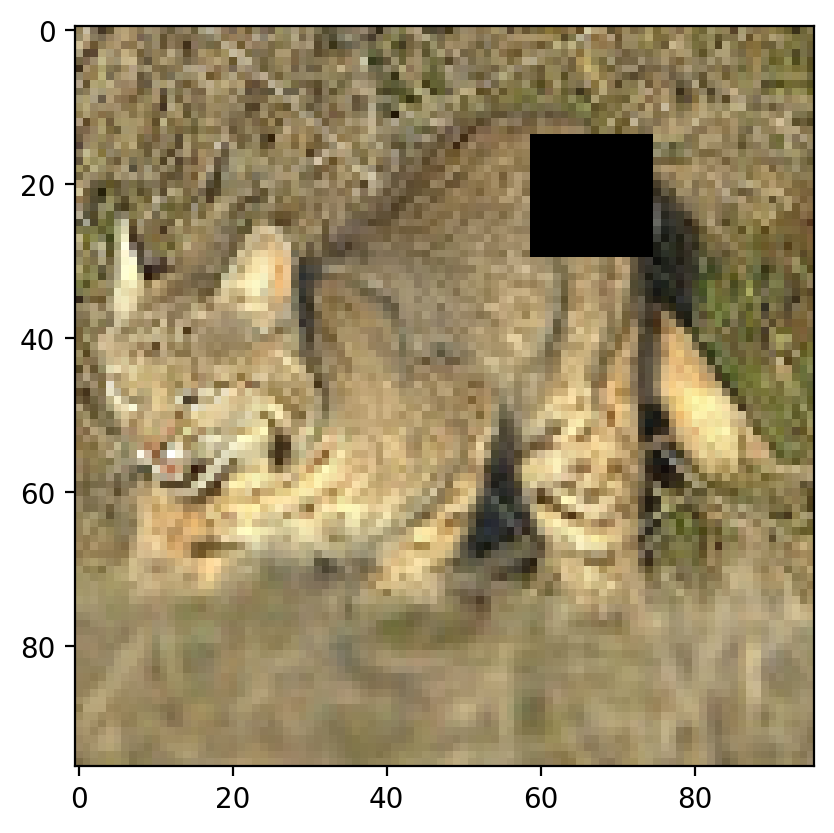

In [ ]:
for i in range(len(trainset)):

  img, label_class = trainset.__getitem__(i)

  if label_class == 1:

    print('IMG shape: ', img.shape)
    img_show(img)

    break


One we have defined the Dataset, we can define train and test dataloaders!

In [ ]:
batch_size = 32
valid_size = 500

# Training partition
part_tr = torch.utils.data.random_split(trainset, [len(trainset)-valid_size, valid_size])[0]
# Use sampler for randomization
training_sampler = torch.utils.data.SubsetRandomSampler(range(len(part_tr)))
# Define the dataloader
trainloader = torch.utils.data.DataLoader(part_tr, batch_size=batch_size, sampler=training_sampler)

# Validation partition
part_val = torch.utils.data.random_split(trainset, [valid_size, len(trainset)-valid_size])[0]
# Use sampler for randomization
valid_sampler = torch.utils.data.SubsetRandomSampler(range(len(part_val)))
# Define the dataloader
validloader = torch.utils.data.DataLoader(part_val, batch_size=batch_size, sampler=valid_sampler)

# Test partition
# Use sampler for randomization
test_sampler = torch.utils.data.SubsetRandomSampler(range(len(testset)))
# Define the dataloader
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, sampler=test_sampler)

In [ ]:
print('TRAIN: ', len(part_tr))
print('VALIDATION: ', len(part_val))
print('TEST: ', len(testset))

TRAIN:  4500
VALIDATION:  500
TEST:  8000


# PART II: Define the CBAM

***SPATIAL ATTENTION MODULE (SAM)***

<figure>
<center><img src="https://blog.paperspace.com/content/images/2020/05/Capture-2.PNG" width="70%"></center>
</figure>

Spatial Attention Module (SAM) is comprised of a three-fold sequential operation.  

*   **Channel Pool**: the Input Tensor of dimensions `(c × h × w)` is decomposed to 2 channels, i.e. `(2 × h × w)`, where each of the 2 channels represent Max Pooling and Average Pooling across the channels.
*   **Convolution layer** which outputs a 1-channel feature map, i.e., the dimension of the output is `(1 × h × w)`. Thus, this convolution layer is a spatial dimension preserving convolution and uses padding to do the same. In code, the convolution is followed by a Batch Norm layer to normalize and scale the output of convolution. However, the authors have also provided an option to use ReLU activation function after the Convolution layer, but by default it only uses Convolution + Batch Norm.
*   **Sigmoid Activation layer**, which will map all the values to a range between 0 and 1.

This Spatial Attention mask is then applied to all the feature maps in the input tensor using a simple element-wise product.

> **Exercise**: complete the following code.

In [ ]:
# 1. Channel Pool
class ChannelPool(nn.Module):

    def forward(self, x):

        out = torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

        return out

In [ ]:
# 2. Convolution Layer (+ Batch Normalization + ReLU activation)

class BasicConv(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):

        super(BasicConv, self).__init__()

        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, dilation, groups, bias)
        self.bn = nn.BatchNorm2d(out_planes) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):

        x = self.conv(x)

        if self.bn is not None:
            x = self.bn(x)

        if self.relu is not None:
            x = self.relu(x)

        return x


In [ ]:
# === SPATIAL ATTENTION MODULE (SAM) === #

class SpatialGate(nn.Module):

    def __init__(self):

        super(SpatialGate, self).__init__()

        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
        self.sigmoid = nn.Sigmoid()

        # NOTE:
        # // -> Divides the number on its left by the number on its right, rounds down the answer, and returns a whole number.

    def forward(self, x):

        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = self.sigmoid(x_out)

        return x * scale

***CHANNEL ATTENTION MODULE (CAM)***

<figure>
<center><img src="https://blog.paperspace.com/content/images/2020/05/Capture-3.PNG" width="70%"></center>
</figure>

The Channel Attention Module (CAM) is another sequential operation but a bit more complex than Spatial Attention Module (SAM).

*  It first decomposes the input tensor into 2 subsequent vectors of dimensionality `(c × 1 × 1)`. One of these vectors is generated by **Global Average Pooling (GAP)** while the other vector is generated by **Global Max Pooling (GMP)**.

    *   **Average Pooling**: aggregates spatial information, it has a smoothing effect.
    *   **Max Pooling**: it preserves much richer contextual information in the form of edges of the object within the image which thus leads to finer channel attention. It preserves natural edges of the objects more precisely.

*  This vector is passed to a **Multi Layer Perceptron (MLP)** network which has a bottleneck whose width or number of neurons is decided by the reduction ratio (r). The higher the reduction ratio, the fewer the number of neurons in the bottleneck and vice versa.

*   The output is the passed to a **Sigmoid activation layer** which then maps the values within the range of 0 and 1.

> **Exercise**: complete the following code.


In [ ]:
# AUXILIAR MODULE

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

In [ ]:
# Early Stopping class, obtained from https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
# We decided to use this class since we observed that, with the given number of epochs (30), the model was far
# from overfitting and could be trained further. To avoid wasting time trying to find the ideal number of epochs,
# we can just train the model until the validation loss hasn't improved in *patience* epochs.

class EarlyStopping:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.early_stop = False

    def __call__(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True



In [ ]:
# === CHANNEL ATTENTION MODULE (CAM) === #

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16):

        super(ChannelGate, self).__init__()

        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
        channel_att_avg = self.mlp(avg_pool)

        max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
        channel_att_max = self.mlp(max_pool)

        channel_att = self.sigmoid(channel_att_avg+channel_att_max)

        scale = channel_att.unsqueeze(2).unsqueeze(3).expand_as(x) # mask for the three channels

        return x * scale



***COMPLETE CBAM!***
> **Exercise**: complete the following code.

In [ ]:
# === CONVOLUTIONAL BLOCK ATTENTION MODULE (CBAM) === #

class CBAM(nn.Module):

    def __init__(self, gate_channels, reduction_ratio=16, no_spatial=False):
        super(CBAM, self).__init__()

        self.ChannelGate = ChannelGate(gate_channels)
        self.no_spatial=no_spatial

        if not no_spatial:
            self.SpatialGate = SpatialGate()

    def forward(self, x):

        x_out = x*self.ChannelGate(x)

        if not self.no_spatial:
            x_out = x_out*self.SpatialGate(x_out)

        return x_out

**CBAM** is applied as a layer in every convolutional block of a convolutional neural network model. It takes in a tensor containing the feature maps from the previous convolutional layer and first refines it by applying channel attention using **CAM**. Subsequently this refined tensor is passed to **SAM** where the spatial attention is applied, thus resulting in the output refined feature maps.

Now let's define a simple network including CBAM.

> **Exercise**: complete the following code.

In [ ]:
# Convolutional block
class ConvPart(nn.Module):

    def __init__(self):

        super().__init__()

        # Convolution and Max Pooling
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, padding=2)

        # Batch Normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)

        # Activation
        self.relu = nn.ReLU()

    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.pool1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.pool2(out)

        out = self.conv3(out)
        return out

In [ ]:
# Full network including CBAM
class NetCBAM(nn.Module):

    def __init__(self, gate_channels=32):

        super().__init__()

        self.gate_channels = gate_channels

        # NN Blocks
        self.conv = ConvPart()
        self.attn1 = CBAM(gate_channels)
        self.linear = nn.Linear(self.gate_channels, 1)

    def forward(self, x):

        out_conv = self.conv(x)
        out_attn = self.attn1(out_conv)
        out = out_attn.mean(3).mean(2)
        out = self.linear(out)
        out = torch.sigmoid(out)[:,0]

        return out, out_attn

The following class completes the implementation of our network, extending it with a training method.

> **Exercise**: complete the following code.

In [ ]:
class NetCBAM_extended(NetCBAM):

    def __init__(self, gate_channels=32, lr=1e-3,epochs=20):

        super().__init__(gate_channels)

        # TRAINING VARIABLES
        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs

        # CRITERION
        self.criterion = nn.BCELoss()

        # LOSS EVOLUTION
        self.loss_during_training = []
        self.valid_loss_during_training = []

        # ACCURACY EVOLUTION
        self.acc_during_training = []
        self.acc_during_validation = []

        # GPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)


    def trainloop(self, trainloader, validloader, patience=10):

        self.train()
        earlyStopping = EarlyStopping(patience=patience)

        for e in range(int(self.epochs)):

          running_loss = 0.
          running_acc = 0.

          for images, labels in tqdm(trainloader, desc=f"Epoch {e+1}/{self.epochs}"):

            images = images.to(self.device)
            labels = labels.to(self.device)

            self.optim.zero_grad()

            probs, _ = self.forward(images)

            loss = self.criterion(probs, labels)

            loss.backward()

            self.optim.step()

            running_loss += loss.item()

            pred = torch.round(probs)
            equals = (pred == labels)
            running_acc += torch.mean(equals.type(torch.FloatTensor))

          self.loss_during_training.append(running_loss/len(trainloader))
          self.acc_during_training.append(running_acc/len(trainloader))
          torch.save(self.state_dict(), f'model_weights_{e}.pth')
          # Validation
          # Turn off gradients for validation, saves memory and computations
          with torch.no_grad():

              running_loss = 0.
              running_acc = 0.

              for images,labels in validloader:

                  images = images.to(self.device)
                  labels = labels.to(self.device)

                  probs, _ = self.forward(images)

                  loss = self.criterion(probs,labels)

                  pred = torch.round(probs)
                  equals = (pred == labels)
                  running_acc += torch.mean(equals.type(torch.FloatTensor))
                  running_loss += loss.item()

              self.valid_loss_during_training.append(running_loss/len(validloader))
              self.acc_during_validation.append(running_acc/len(validloader))
              earlyStopping(self.valid_loss_during_training[-1])


          print('\nTrain Epoch: {} -> Training Loss: {:.6f}'.format(e,self.loss_during_training[-1]))
          print('Train Epoch: {} -> Validation Loss: {:.6f}'.format(e,self.valid_loss_during_training[-1]))

          if earlyStopping.early_stop:
            self.load_state_dict(torch.load(f'model_weights_{e - patience}.pth'))
            print('Stopping training due to early stopping')
            break

    def eval_performance(self, dataloader):

        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)
                probs, _ = self.forward(images)

                labels_pred = torch.round(probs)
                equals = (labels_pred == labels)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

            return accuracy/len(dataloader)

> **Exercise**: Train the model for 30 epochs. Plot the evolution of train and validation losses. Is the network overfitting?

Epoch 1/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 0 -> Training Loss: 0.689310
Train Epoch: 0 -> Validation Loss: 0.570709


Epoch 2/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 1 -> Training Loss: 0.343616
Train Epoch: 1 -> Validation Loss: 0.168930


Epoch 3/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 2 -> Training Loss: 0.142266
Train Epoch: 2 -> Validation Loss: 0.120738


Epoch 4/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 3 -> Training Loss: 0.130575
Train Epoch: 3 -> Validation Loss: 0.106874


Epoch 5/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 4 -> Training Loss: 0.118445
Train Epoch: 4 -> Validation Loss: 0.083759


Epoch 6/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 5 -> Training Loss: 0.088316
Train Epoch: 5 -> Validation Loss: 0.079818


Epoch 7/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 6 -> Training Loss: 0.078362
Train Epoch: 6 -> Validation Loss: 0.071110


Epoch 8/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 7 -> Training Loss: 0.059797
Train Epoch: 7 -> Validation Loss: 0.060930


Epoch 9/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 8 -> Training Loss: 0.069473
Train Epoch: 8 -> Validation Loss: 0.092171


Epoch 10/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 9 -> Training Loss: 0.061437
Train Epoch: 9 -> Validation Loss: 0.069470


Epoch 11/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 10 -> Training Loss: 0.054003
Train Epoch: 10 -> Validation Loss: 0.074800


Epoch 12/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 11 -> Training Loss: 0.073061
Train Epoch: 11 -> Validation Loss: 0.056888


Epoch 13/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 12 -> Training Loss: 0.053743
Train Epoch: 12 -> Validation Loss: 0.040085


Epoch 14/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 13 -> Training Loss: 0.042080
Train Epoch: 13 -> Validation Loss: 0.024867


Epoch 15/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 14 -> Training Loss: 0.051315
Train Epoch: 14 -> Validation Loss: 0.029229


Epoch 16/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 15 -> Training Loss: 0.037141
Train Epoch: 15 -> Validation Loss: 0.034550


Epoch 17/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 16 -> Training Loss: 0.038970
Train Epoch: 16 -> Validation Loss: 0.029372


Epoch 18/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 17 -> Training Loss: 0.036039
Train Epoch: 17 -> Validation Loss: 0.028926


Epoch 19/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 18 -> Training Loss: 0.040749
Train Epoch: 18 -> Validation Loss: 0.044429


Epoch 20/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 19 -> Training Loss: 0.043442
Train Epoch: 19 -> Validation Loss: 0.043013


Epoch 21/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 20 -> Training Loss: 0.042644
Train Epoch: 20 -> Validation Loss: 0.037177


Epoch 22/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 21 -> Training Loss: 0.037524
Train Epoch: 21 -> Validation Loss: 0.033899


Epoch 23/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 22 -> Training Loss: 0.032295
Train Epoch: 22 -> Validation Loss: 0.025766


Epoch 24/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 23 -> Training Loss: 0.045318
Train Epoch: 23 -> Validation Loss: 0.054739
Stopping training due to early stopping


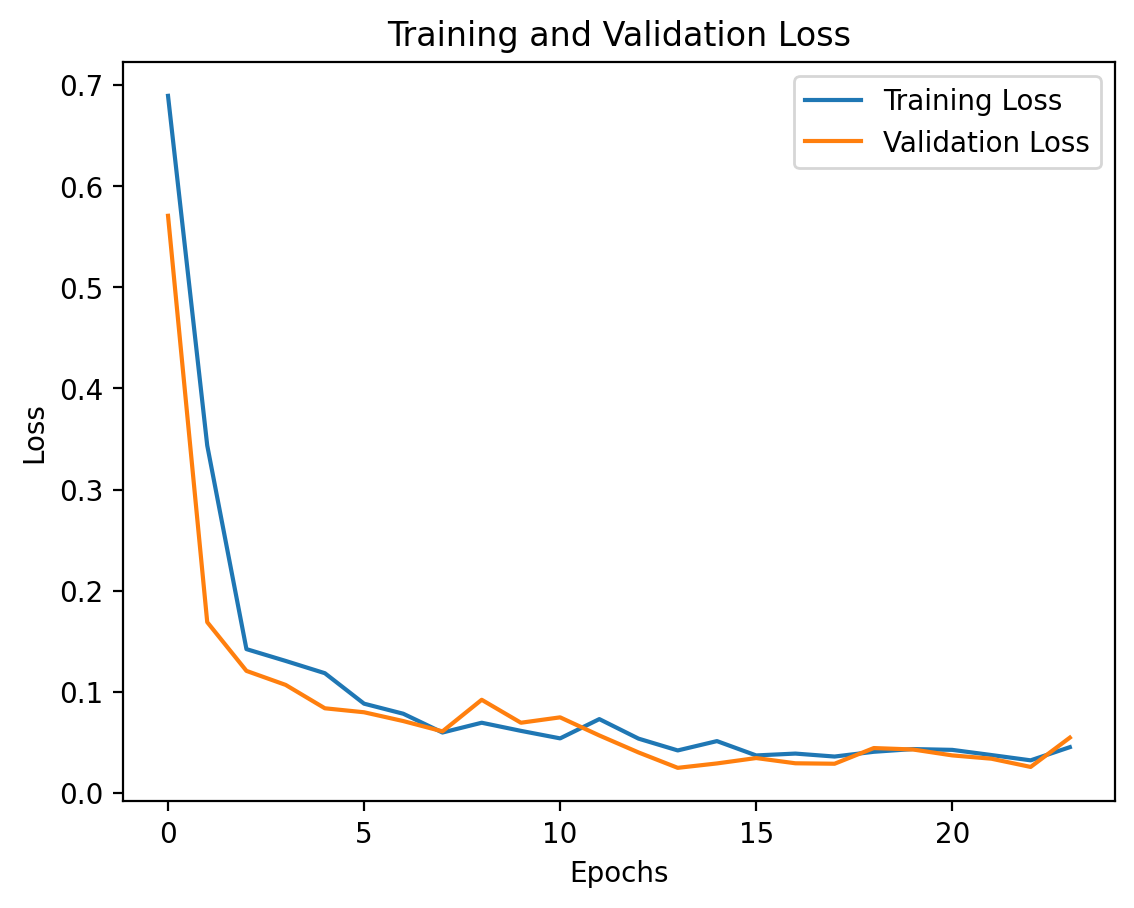

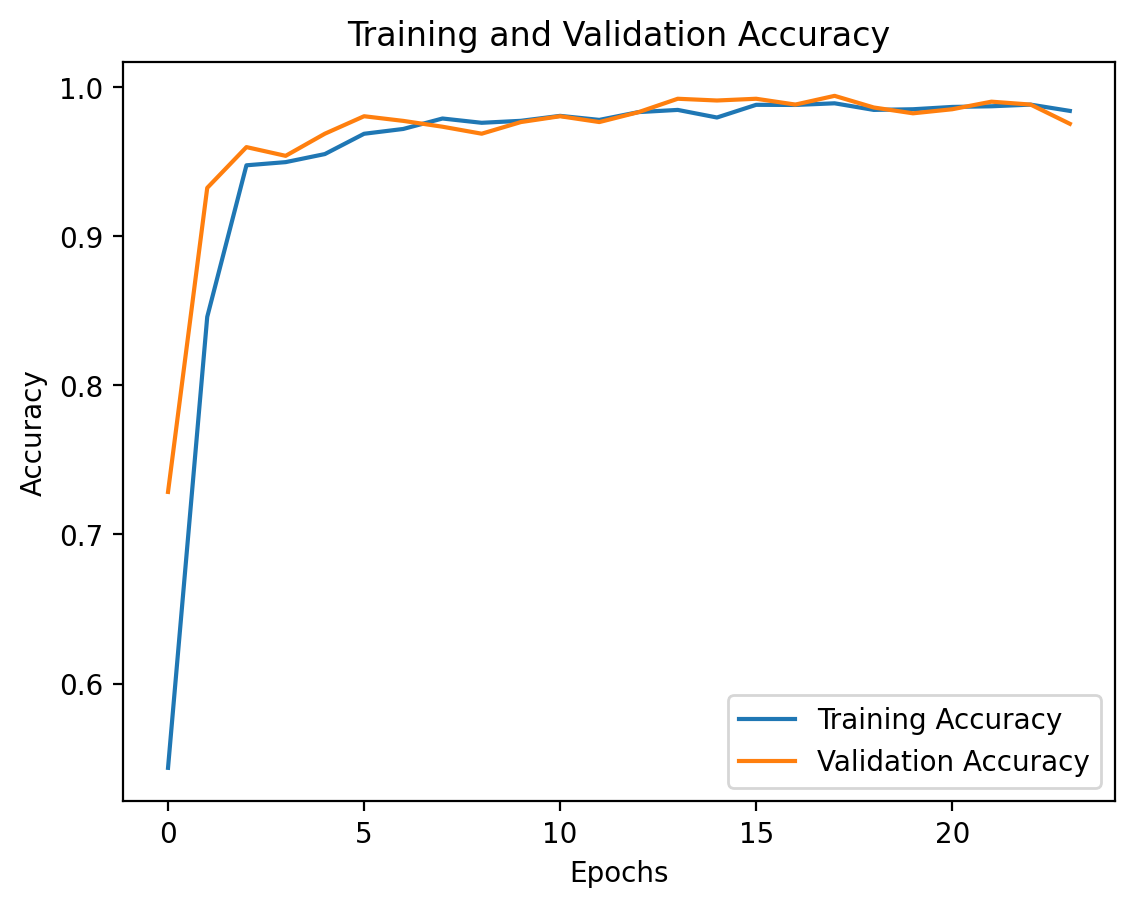

In [ ]:
# Por defecto, vienen 30 épocas, pero tras analizar los resultados obtenidos con este
# número hemos llegado a la conclusión de que el modelo se puede entrenar durante más épocas,
# puesto que ni el error de entrenamiento ni el de validación aumentarón en ningún momento
# del entrenamiento (no había sobre ajuste al conjunto de datos de entrenamiento)

n_epochs = 100
cbam = NetCBAM_extended(epochs=n_epochs)
cbam.trainloop(trainloader, validloader, patience=10)

epochs = range(0, len(cbam.loss_during_training))

plt.plot(epochs, cbam.loss_during_training, label='Training Loss')
plt.plot(epochs, cbam.valid_loss_during_training, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, cbam.acc_during_training, label='Training Accuracy')
plt.plot(epochs, cbam.acc_during_validation, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

> **Exercise**: Evaluate the performance of the model in the different data partitions.

Podemos observar que el modelo entrena de forma satisfactoria: el error del modelo en los conjuntos de entrenamiento y validación no se incrementa de forma constante en ningún momento y son bastante similares durante todo el entrenamiento. La precisión del modelo en ambos conjuntos aumenta siempre en todo momento, llegando a rozar el 100%. El entrenamiento del modelo se pausa en la época 23, ya que el error de validación no había mejorado en las últimas 10 épocas.

In [ ]:
# YOUR CODE HERE
print("Accuracy en el conjunto de entrenamiento:", cbam.eval_performance(trainloader).item())
print("Accuracy en el conjunto de validación:", cbam.eval_performance(validloader).item())
print("Accuracy en el conjunto de test:", cbam.eval_performance(testloader).item())

Accuracy en el conjunto de entrenamiento: 0.9880319237709045
Accuracy en el conjunto de validación: 0.990234375
Accuracy en el conjunto de test: 0.9866250157356262


Tras observar la precisión del modelo en los conjuntos de datos de entrenamiento, validación y test, podemos concluir que el modelo ha entrenado de forma satisfactoria. Al tener obtener los mismos resultados en validación y test que en entrenamiento, se puede razonar que el modelo no está sobre ajustado al conjunto de datos de entrenamiento. De ser así, el modelo presentaría un rendimiento más alto en este conjunto que sobre el de validación y test.


> **Exercise**: complete the following code to visualize some of the obtaines attention maps. Discuss the obtained results.

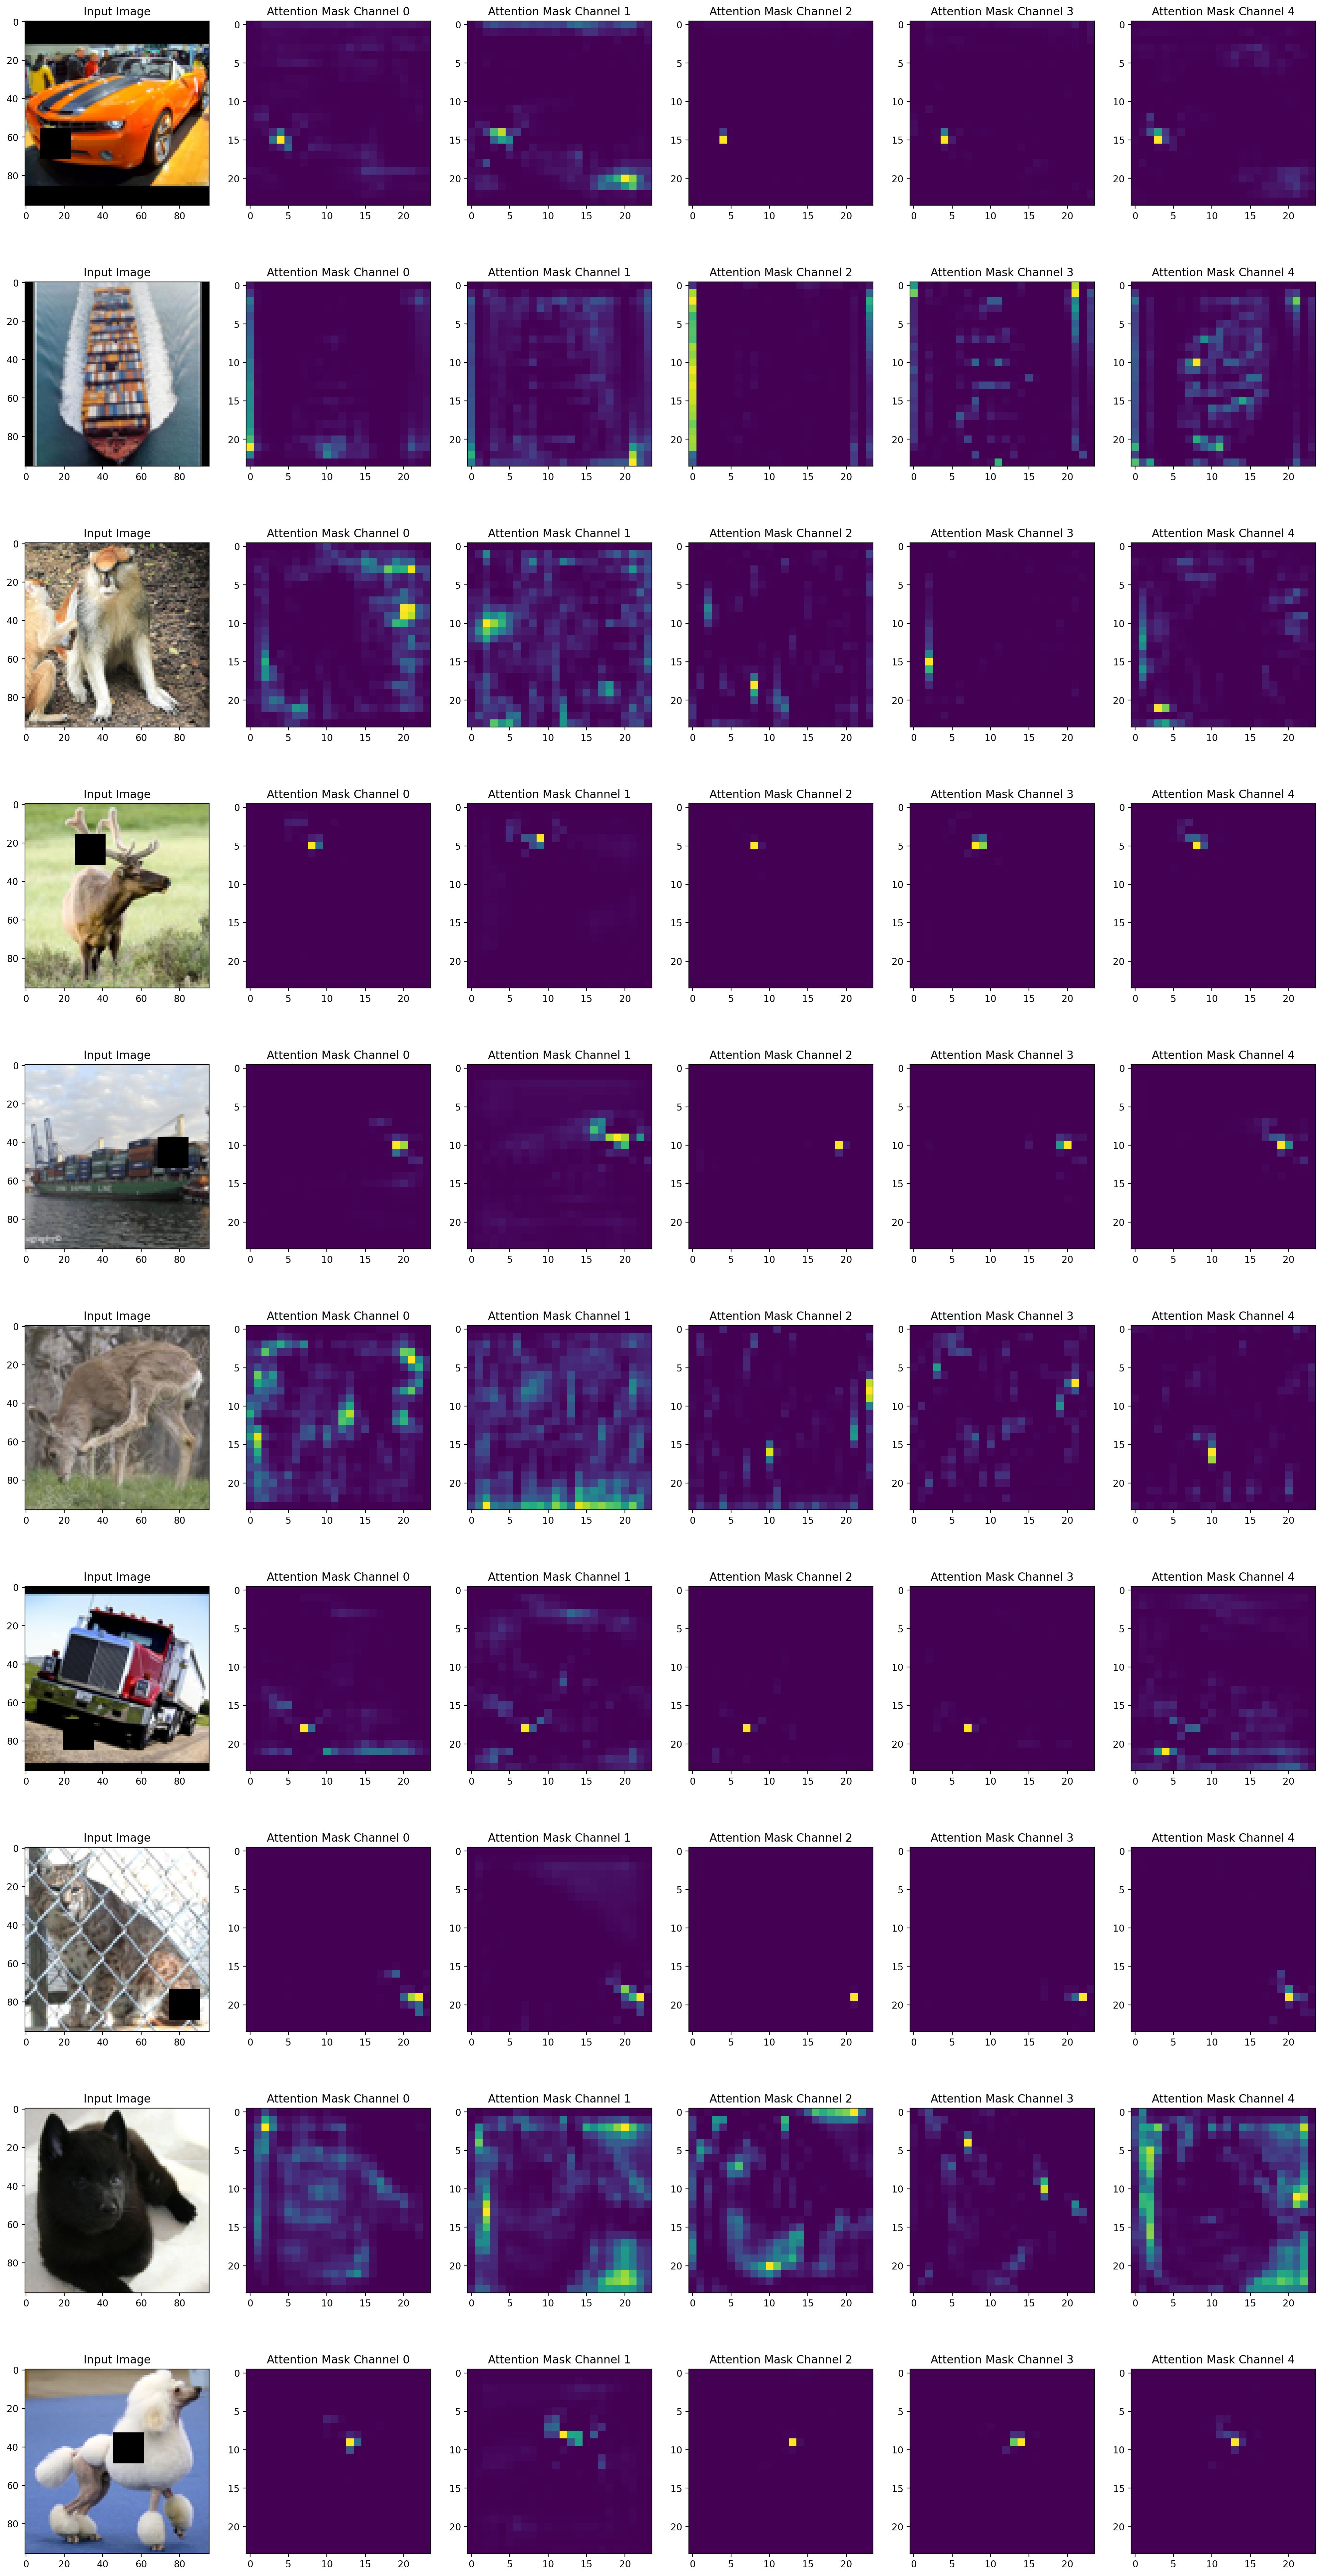

In [ ]:
img, labels = next(iter(testloader))
img, labels = img.to(cbam.device), labels.to(cbam.device)

_, attn = cbam.forward(img)


fig, axes = plt.subplots(10, 6, figsize=(5*5, 10*5))

for i in range(10):
    img_plot = np.transpose(img[i,:,:,:].cpu().detach().numpy(), (1, 2, 0))
    img_plot = img_plot / 2 + 0.5
    axes[i, 0].imshow(img_plot)
    axes[i, 0].set_title("Input Image")
    axes[i, 1].imshow(attn[i,0,:,:].cpu().detach().numpy())
    axes[i, 1].set_title("Attention Mask Channel 0")
    axes[i, 2].imshow(attn[i,1,:,:].cpu().detach().numpy())
    axes[i, 2].set_title("Attention Mask Channel 1")
    axes[i, 3].imshow(attn[i,2,:,:].cpu().detach().numpy())
    axes[i, 3].set_title("Attention Mask Channel 2")
    axes[i, 4].imshow(attn[i,3,:,:].cpu().detach().numpy())
    axes[i, 4].set_title("Attention Mask Channel 3")
    axes[i, 5].imshow(attn[i,4,:,:].cpu().detach().numpy())
    axes[i, 5].set_title("Attention Mask Channel 4")


En aquellas imágenes donde hay un cuadrado obstruyendo la imagen, las capas de atención resaltan los pixéles del cuadrado, tal y como cabría de esperar. Esto lo que hace es potenciar los píxeles pertenecientes al cuadrado mientras reduce la importancia del resto, lo cual ayuda al modelo en su predicción.

También resultan interesantes los resultados de las capas de atención en aquellas imágenes que no tienen el cuadrado. Las capas de atención parecen realzar aquellas partes de la imágen donde todos los píxeles son semejantes entre sí. También cabe destacar que las capas de atención parecen más activas en las imágenes sin el cuadrado, mientras que en las imágenes con el cuadrado, prácticamente solo se activan en los píxeles correspondientes a éste.

> **OPTIONAL EXERCISE**: compare the results obtained using the CBAM block with the ones obtained using a network that hasn't attention.

In [ ]:
class NetConv(nn.Module):

    def __init__(self):

        super().__init__()

        # NN Blocks
        self.conv = ConvPart()
        self.linear = nn.Linear(32*24*24, 1)

    def forward(self, x):

        out_conv = self.conv(x)
        out_conv = Flatten()(out_conv)
        out_conv = self.linear(out_conv)
        out_conv = torch.sigmoid(out_conv)[:,0]

        return out_conv

In [ ]:
class NetConv_extended(NetConv):

    def __init__(self, lr=1e-3,epochs=20):

        super().__init__()

        # TRAINING VARIABLES
        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs

        # CRITERION
        self.criterion = nn.BCELoss()

        # LOSS EVOLUTION
        self.loss_during_training = []
        self.valid_loss_during_training = []

        # ACCURACY EVOLUTION
        self.acc_during_training = []
        self.acc_during_validation = []

        # GPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)


    def trainloop(self, trainloader, validloader, patience=10):

        self.train()
        earlyStopping = EarlyStopping(patience=patience)

        for e in range(int(self.epochs)):

          running_loss = 0.
          running_acc = 0.

          for images, labels in tqdm(trainloader, desc=f"Epoch {e+1}/{self.epochs}"):

            images = images.to(self.device)
            labels = labels.to(self.device)

            self.optim.zero_grad()

            probs = self.forward(images)

            loss = self.criterion(probs, labels)

            loss.backward()

            self.optim.step()

            running_loss += loss.item()

            pred = torch.round(probs)
            equals = (pred == labels)
            running_acc += torch.mean(equals.type(torch.FloatTensor))

          self.loss_during_training.append(running_loss/len(trainloader))
          self.acc_during_training.append(running_acc/len(trainloader))
          torch.save(self.state_dict(), f'cnn_weights_{e}.pth')

          # Validation
          # Turn off gradients for validation, saves memory and computations
          with torch.no_grad():

              running_loss = 0.
              running_acc = 0.

              for images,labels in validloader:

                  images = images.to(self.device)
                  labels = labels.to(self.device)

                  probs = self.forward(images)

                  loss = self.criterion(probs,labels)

                  pred = torch.round(probs)
                  equals = (pred == labels)
                  running_acc += torch.mean(equals.type(torch.FloatTensor))
                  running_loss += loss.item()

              self.valid_loss_during_training.append(running_loss/len(validloader))
              self.acc_during_validation.append(running_acc/len(validloader))
              earlyStopping(self.valid_loss_during_training[-1])

          print('\nTrain Epoch: {} -> Training Loss: {:.6f}'.format(e,self.loss_during_training[-1]))
          print('Train Epoch: {} -> Validation Loss: {:.6f}'.format(e,self.valid_loss_during_training[-1]))

          if earlyStopping.early_stop:
            self.load_state_dict(torch.load(f'cnn_weights_{e - patience}.pth'))
            print('Stopping training due to early stopping')
            break

    def eval_performance(self, dataloader):

        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)
                probs  = self.forward(images)

                labels_pred = torch.round(probs)
                equals = (labels_pred == labels)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

            return accuracy/len(dataloader)

Epoch 1/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 0 -> Training Loss: 0.780948
Train Epoch: 0 -> Validation Loss: 0.712330


Epoch 2/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 1 -> Training Loss: 0.724798
Train Epoch: 1 -> Validation Loss: 0.692162


Epoch 3/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 2 -> Training Loss: 0.716167
Train Epoch: 2 -> Validation Loss: 0.700935


Epoch 4/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 3 -> Training Loss: 0.710126
Train Epoch: 3 -> Validation Loss: 0.706579


Epoch 5/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 4 -> Training Loss: 0.716827
Train Epoch: 4 -> Validation Loss: 0.679050


Epoch 6/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 5 -> Training Loss: 0.695234
Train Epoch: 5 -> Validation Loss: 0.648433


Epoch 7/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 6 -> Training Loss: 0.678710
Train Epoch: 6 -> Validation Loss: 0.634754


Epoch 8/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 7 -> Training Loss: 0.652266
Train Epoch: 7 -> Validation Loss: 0.638072


Epoch 9/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 8 -> Training Loss: 0.635625
Train Epoch: 8 -> Validation Loss: 0.591228


Epoch 10/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 9 -> Training Loss: 0.612910
Train Epoch: 9 -> Validation Loss: 0.670134


Epoch 11/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 10 -> Training Loss: 0.582970
Train Epoch: 10 -> Validation Loss: 0.546398


Epoch 12/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 11 -> Training Loss: 0.537379
Train Epoch: 11 -> Validation Loss: 0.502974


Epoch 13/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 12 -> Training Loss: 0.517972
Train Epoch: 12 -> Validation Loss: 0.418071


Epoch 14/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 13 -> Training Loss: 0.422643
Train Epoch: 13 -> Validation Loss: 0.517673


Epoch 15/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 14 -> Training Loss: 0.397770
Train Epoch: 14 -> Validation Loss: 0.311405


Epoch 16/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 15 -> Training Loss: 0.358588
Train Epoch: 15 -> Validation Loss: 0.354914


Epoch 17/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 16 -> Training Loss: 0.306319
Train Epoch: 16 -> Validation Loss: 0.276572


Epoch 18/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 17 -> Training Loss: 0.343011
Train Epoch: 17 -> Validation Loss: 0.205443


Epoch 19/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 18 -> Training Loss: 0.280777
Train Epoch: 18 -> Validation Loss: 0.219431


Epoch 20/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 19 -> Training Loss: 0.239251
Train Epoch: 19 -> Validation Loss: 0.298060


Epoch 21/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 20 -> Training Loss: 0.232799
Train Epoch: 20 -> Validation Loss: 0.214668


Epoch 22/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 21 -> Training Loss: 0.270877
Train Epoch: 21 -> Validation Loss: 0.241111


Epoch 23/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 22 -> Training Loss: 0.225978
Train Epoch: 22 -> Validation Loss: 0.198136


Epoch 24/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 23 -> Training Loss: 0.225091
Train Epoch: 23 -> Validation Loss: 0.242204


Epoch 25/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 24 -> Training Loss: 0.217744
Train Epoch: 24 -> Validation Loss: 0.116735


Epoch 26/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 25 -> Training Loss: 0.176272
Train Epoch: 25 -> Validation Loss: 0.169615


Epoch 27/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 26 -> Training Loss: 0.219043
Train Epoch: 26 -> Validation Loss: 0.111344


Epoch 28/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 27 -> Training Loss: 0.185482
Train Epoch: 27 -> Validation Loss: 0.163696


Epoch 29/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 28 -> Training Loss: 0.182047
Train Epoch: 28 -> Validation Loss: 0.085038


Epoch 30/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 29 -> Training Loss: 0.140820
Train Epoch: 29 -> Validation Loss: 0.103292


Epoch 31/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 30 -> Training Loss: 0.178364
Train Epoch: 30 -> Validation Loss: 0.107464


Epoch 32/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 31 -> Training Loss: 0.116419
Train Epoch: 31 -> Validation Loss: 0.115156


Epoch 33/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 32 -> Training Loss: 0.164451
Train Epoch: 32 -> Validation Loss: 0.121118


Epoch 34/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 33 -> Training Loss: 0.141832
Train Epoch: 33 -> Validation Loss: 0.103424


Epoch 35/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 34 -> Training Loss: 0.155713
Train Epoch: 34 -> Validation Loss: 0.335337


Epoch 36/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 35 -> Training Loss: 0.165940
Train Epoch: 35 -> Validation Loss: 0.106900


Epoch 37/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 36 -> Training Loss: 0.123717
Train Epoch: 36 -> Validation Loss: 0.092313


Epoch 38/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 37 -> Training Loss: 0.122604
Train Epoch: 37 -> Validation Loss: 0.103365


Epoch 39/100:   0%|          | 0/141 [00:00<?, ?it/s]


Train Epoch: 38 -> Training Loss: 0.111588
Train Epoch: 38 -> Validation Loss: 0.103714
Stopping training due to early stopping


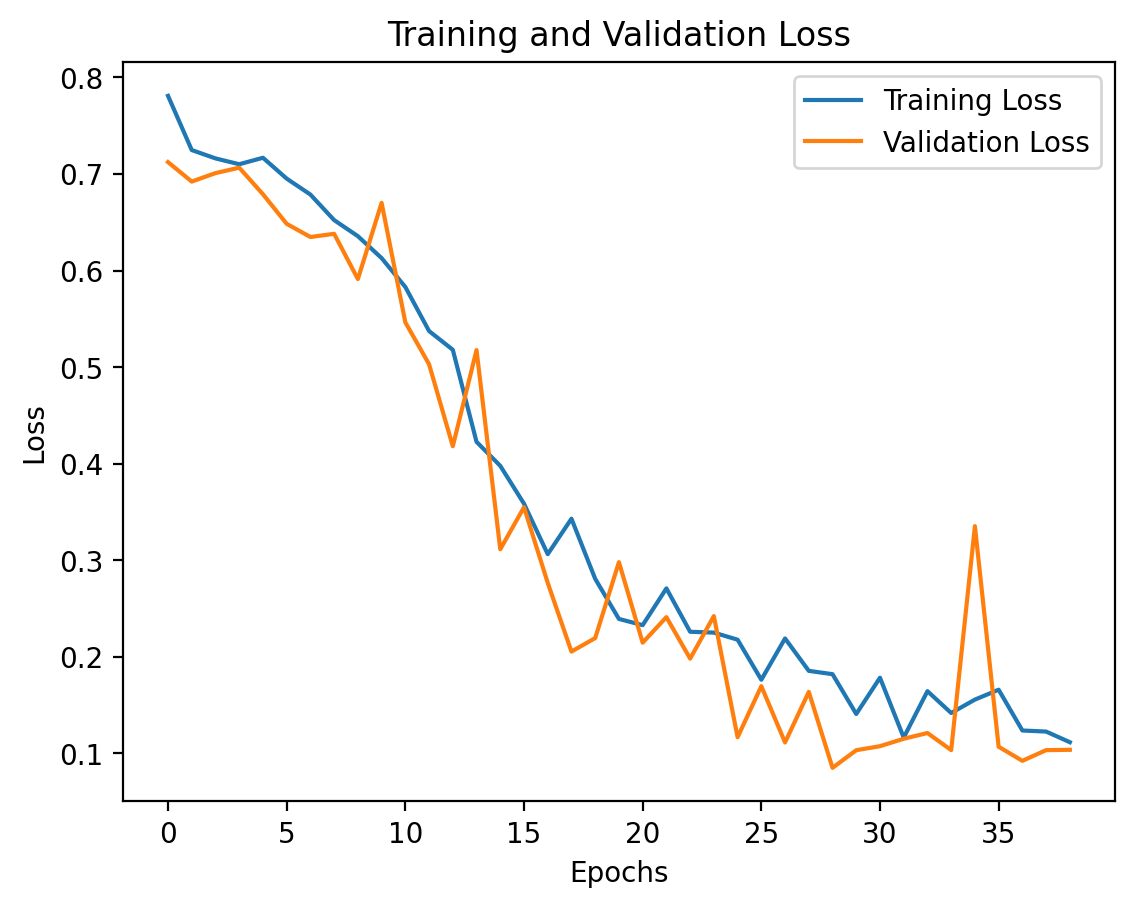

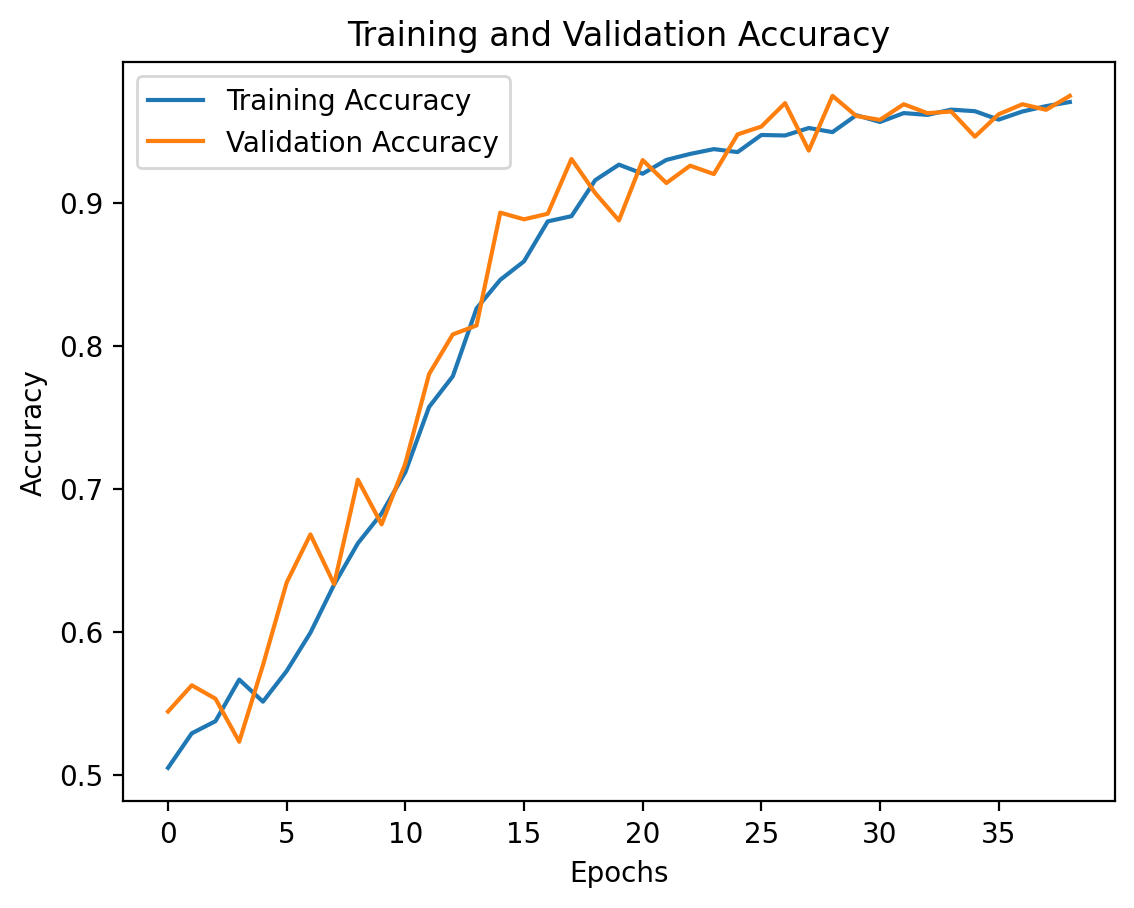

In [ ]:
# Al igual que con el anterior modelo, no hemos encontrado signos de sobreajuste con el número
# de épocas dado, por lo que se puede seguir entrenando

n_epochs = 100
net_conv = NetConv_extended(epochs=n_epochs)
net_conv.trainloop(trainloader, validloader, patience=10)

epochs = range(0, len(net_conv.loss_during_training))

plt.plot(epochs, net_conv.loss_during_training, label='Training Loss')
plt.plot(epochs, net_conv.valid_loss_during_training, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, net_conv.acc_during_training, label='Training Accuracy')
plt.plot(epochs, net_conv.acc_during_validation, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Podemos apreciar como el modelo entrena de forma satisfactoria puesto que tanto el error de entrenamiento como el de validación descienden hasta converger en la época 27, momento a partir del cual no sé mejoró el error de validación en las 10 siguientes etapas.

Cabe resaltar que la precisión del modelo se acerca al 100% tanto en el conjunto de datos de entrenamiento como en el de validación.

In [ ]:
print("Accuracy en el conjunto de entrenamiento:", net_conv.eval_performance(trainloader).item())
print("Accuracy en el conjunto de validación:", net_conv.eval_performance(validloader).item())
print("Accuracy en el conjunto de test:", net_conv.eval_performance(testloader).item())

Accuracy en el conjunto de entrenamiento: 0.9632092118263245
Accuracy en el conjunto de validación: 0.9371093511581421
Accuracy en el conjunto de test: 0.9578750133514404


Tras observar los resultados y compararlos con los obtenidos anteriormente, podemos concluir que la red de atención es algo mejor que la red convolucional, además de que la red con atención tiene un aprendizaje más rápido. No obstante, esta mejora, a pesar de ser relevante, difiere en apenas 3 puntos sobre los resultados sobre el conjunto de test. Esto demuestra que, aunque el modelo que utiliza mecanismos de atención es mejor, la diferencia no es extremadamente notoria.